# Desafío1 - Boosting Classifiers

<br>
<div class="alert alert-block alert-success">

__Integrantes:__ 

- Yerko Carreño
- Javier Pilasi 
- Daniel Flores
- Francisco Fernandez
- Máximo Oliva
- Rocío Ehijo
- Cristián Contreras

<b>Profesor:</b> Rodrigo Abt.

</div>


* Para realizar este desafío debes haber revisado la lectura y videos correspondiente a la unidad.
* Crea una carpeta de trabajo y guarda todos los archivos correspondientes (notebook y csv).
* Una vez terminado el desafío, comprime la carpeta y sube el .zip a la sección correspondiente.


**Decripción**

Para esta actividad desarrollaremos un ensamble heterogéneo que prediga la popularidad o inpopularidad de contenido en línea de un sitio web. El archivo csv tiene un total de 39797 registros, donde cada uno representa características del artículo publicado en el sitio web. Cada registro tiene un total de 61 atributos que miden características del texto, cantidad de imágenes, keywords, etc. Los artículos provienen de la publicación K. Fernandes, P. Vinagre and P. Cortez. A Proactive Intelligent Decision Support System for Predicting the Popularity of Online News. Proceedings of the 17th EPIA 2015 - Portuguese Conference on Artificial Intelligence, September, Coimbra, Portugal. Los artículos registrados son de la página web www.mashable.com.
Más información sobre los atributos se puede encontrar en el archivo OnlineNewsPopularity.names.

## Preprocesamiento

- A continuación se le presenta un código que agrupa las variables por grupos. Cada uno de éstos hace referencia a alguna característica de los registros en la base de datos. Genere una análisis descriptivo de cada uno de los atributos. Puede utilizar la función `grid_plot_batch` que se encuentra en el archivo `helpers.py`.

```python
# las etiquetas de las columnas presentan un espacio extra, con ésto lo podemos eliminar

df.columns = [i.replace(' ', '') for i in df.columns]

# eliminamos el string de url que no sirve para el análisis

df = df.loc[:, 'n_tokens_title':'shares']

# generamos el conjunto de variables
qnty = df.filter(regex='^n_', axis=1)
channel = df.filter(regex='^data_', axis=1)
days = df.filter(regex=re.compile("weekday|weekend"), axis=1)
sentiments = df.filter(regex=re.compile("negative|positive|subjectivity"),
axis=1)
lda = df.filter(regex='^LDA_\d', axis=1)
keywords = df.filter(regex='^kw_', axis=1)
```

- Describa el comportamiento de las variables.
- Dada la naturaleza de los atributos, es probable que algunas mediciones estén correlacionadas entre sí. Para ello, genere un diagnóstico previo de multicolinealidad utilizando la función `identify_high_correlations` que se encuentra en el archivo `helpers.py`. Para todos aquellos atributos que tengan una correlación de .8, reporte sus nombres.
- Antes de generar los conjuntos de entrenamiento y validación, preprocese los datos con los siguientes pasos:
    - Recodifique la variable `shares` en una variable binaria que identifique como 1 todos los registros con más de 1400 "compartir" y 0 de lo contrario. Para evitar multicolinealidad, elimine la variable `shares` posteriormente.
    - Elimine todas las variables que presentaban una correlación mayor a .8. Este paso es para evitar la multicolinealidad de los atributos.
    - Genere un análisis de Componentes Principales para extraer las principales 30 dimensiones. Guarde estas dimensiones en un nuevo objeto.

In [1]:
# Bibliotecas

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

import re
import missingno as msngo
import warnings

from helpers import grid_plot_batch
from helpers import identify_high_correlations
from utils import plot_class_report

from IPython.display import display, Markdown

warnings.filterwarnings('ignore')

### Lectura de base de datos

In [2]:
# Importa base de datos

df = pd.read_csv("OnlineNewsPopularity/OnlineNewsPopularity.csv")

# Elimina espacios en nombre columna

df.columns = [i.replace(' ', '') for i in df.columns]

# Elimina columna de url

df.drop(axis="columns", columns=["url"], inplace=True)

display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 60 columns):
timedelta                        39644 non-null float64
n_tokens_title                   39644 non-null float64
n_tokens_content                 39644 non-null float64
n_unique_tokens                  39644 non-null float64
n_non_stop_words                 39644 non-null float64
n_non_stop_unique_tokens         39644 non-null float64
num_hrefs                        39644 non-null float64
num_self_hrefs                   39644 non-null float64
num_imgs                         39644 non-null float64
num_videos                       39644 non-null float64
average_token_length             39644 non-null float64
num_keywords                     39644 non-null float64
data_channel_is_lifestyle        39644 non-null float64
data_channel_is_entertainment    39644 non-null float64
data_channel_is_bus              39644 non-null float64
data_channel_is_socmed           39644 non-null flo

None

### Análisis descriptivo de datos

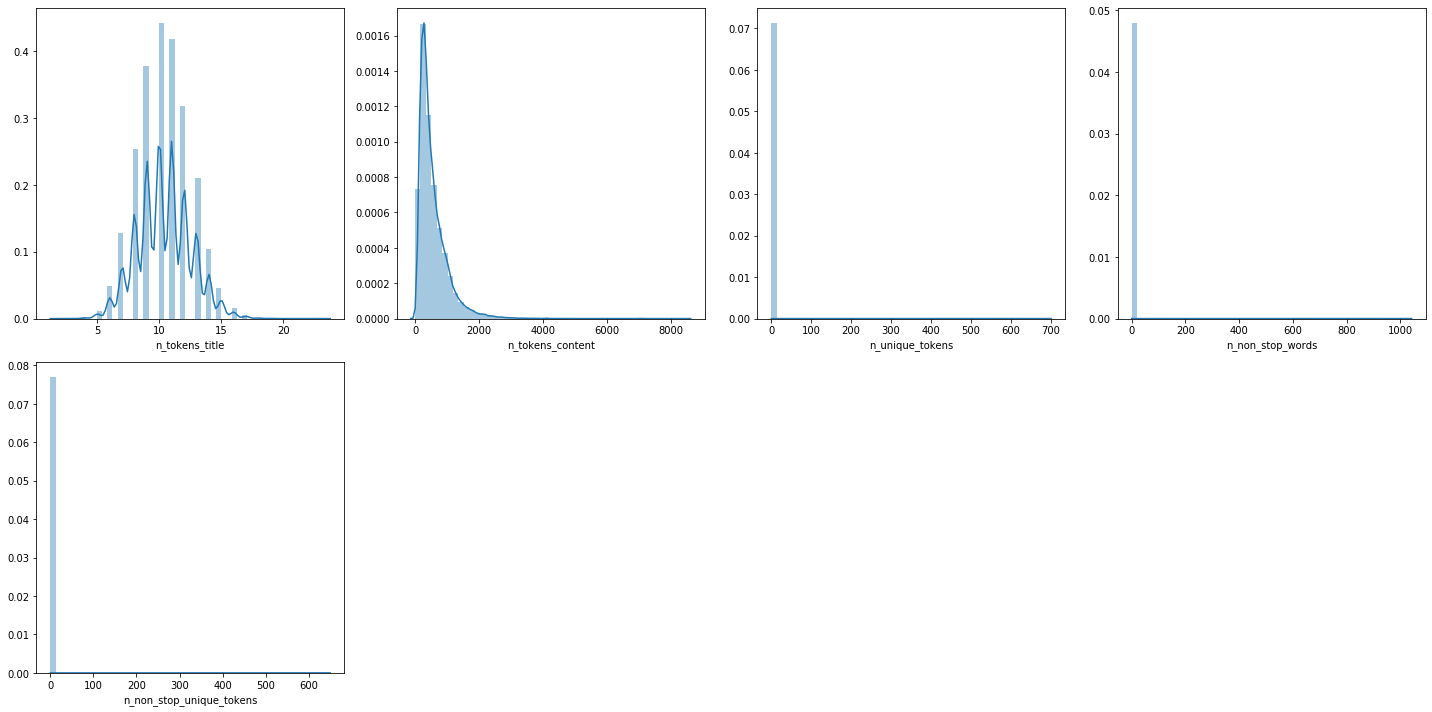

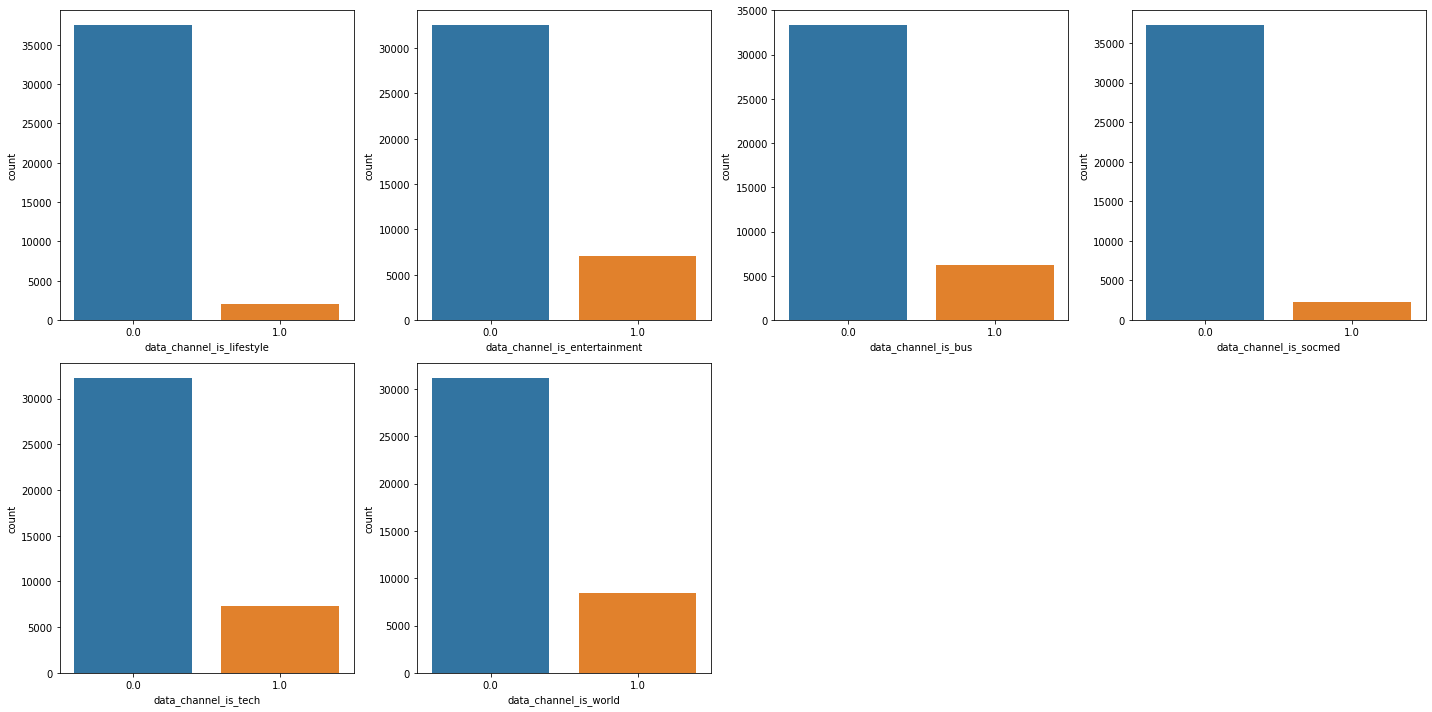

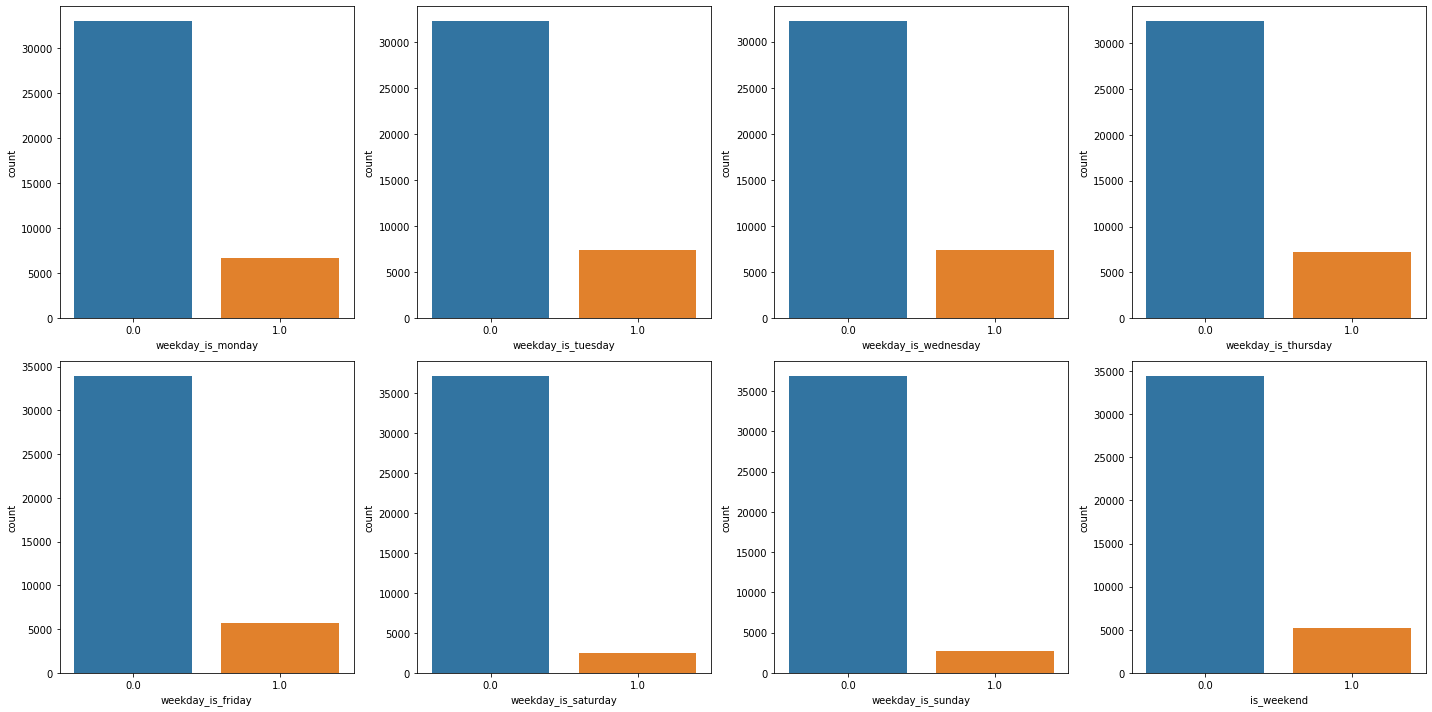

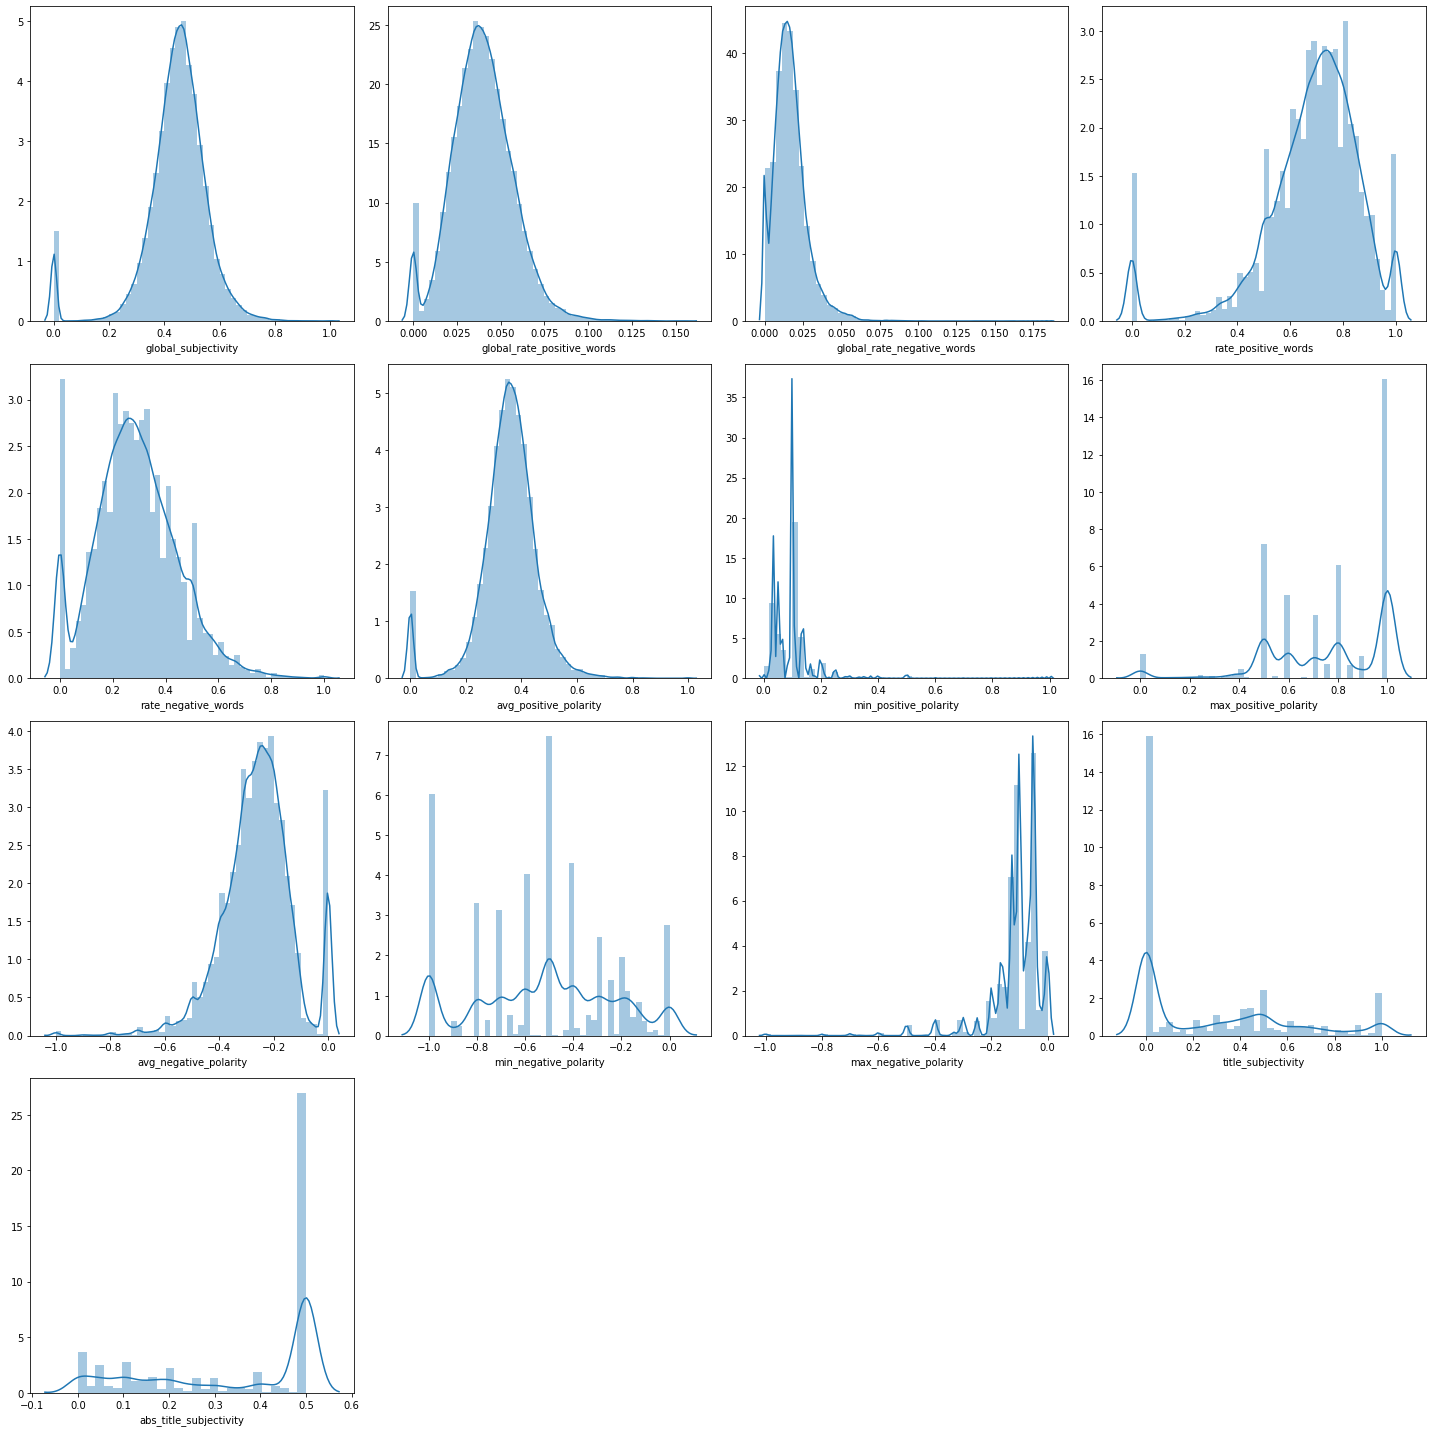

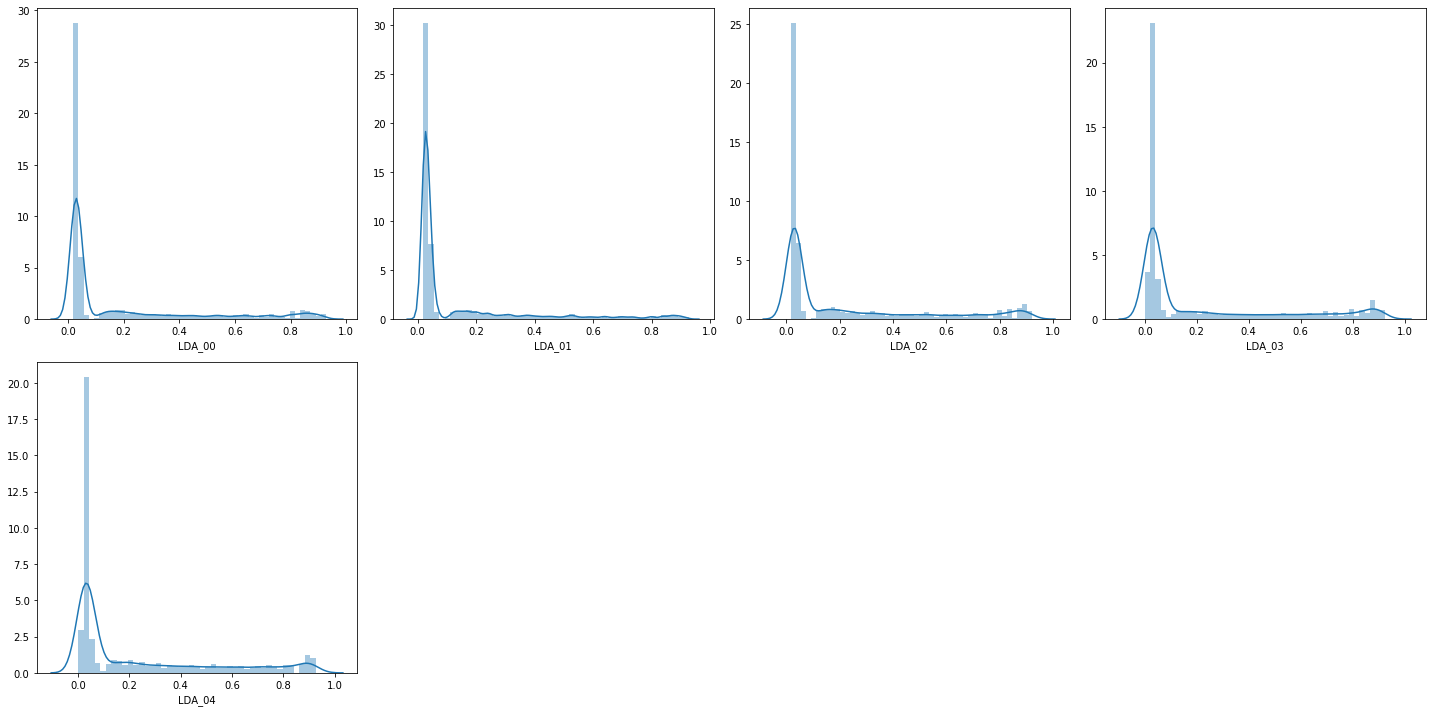

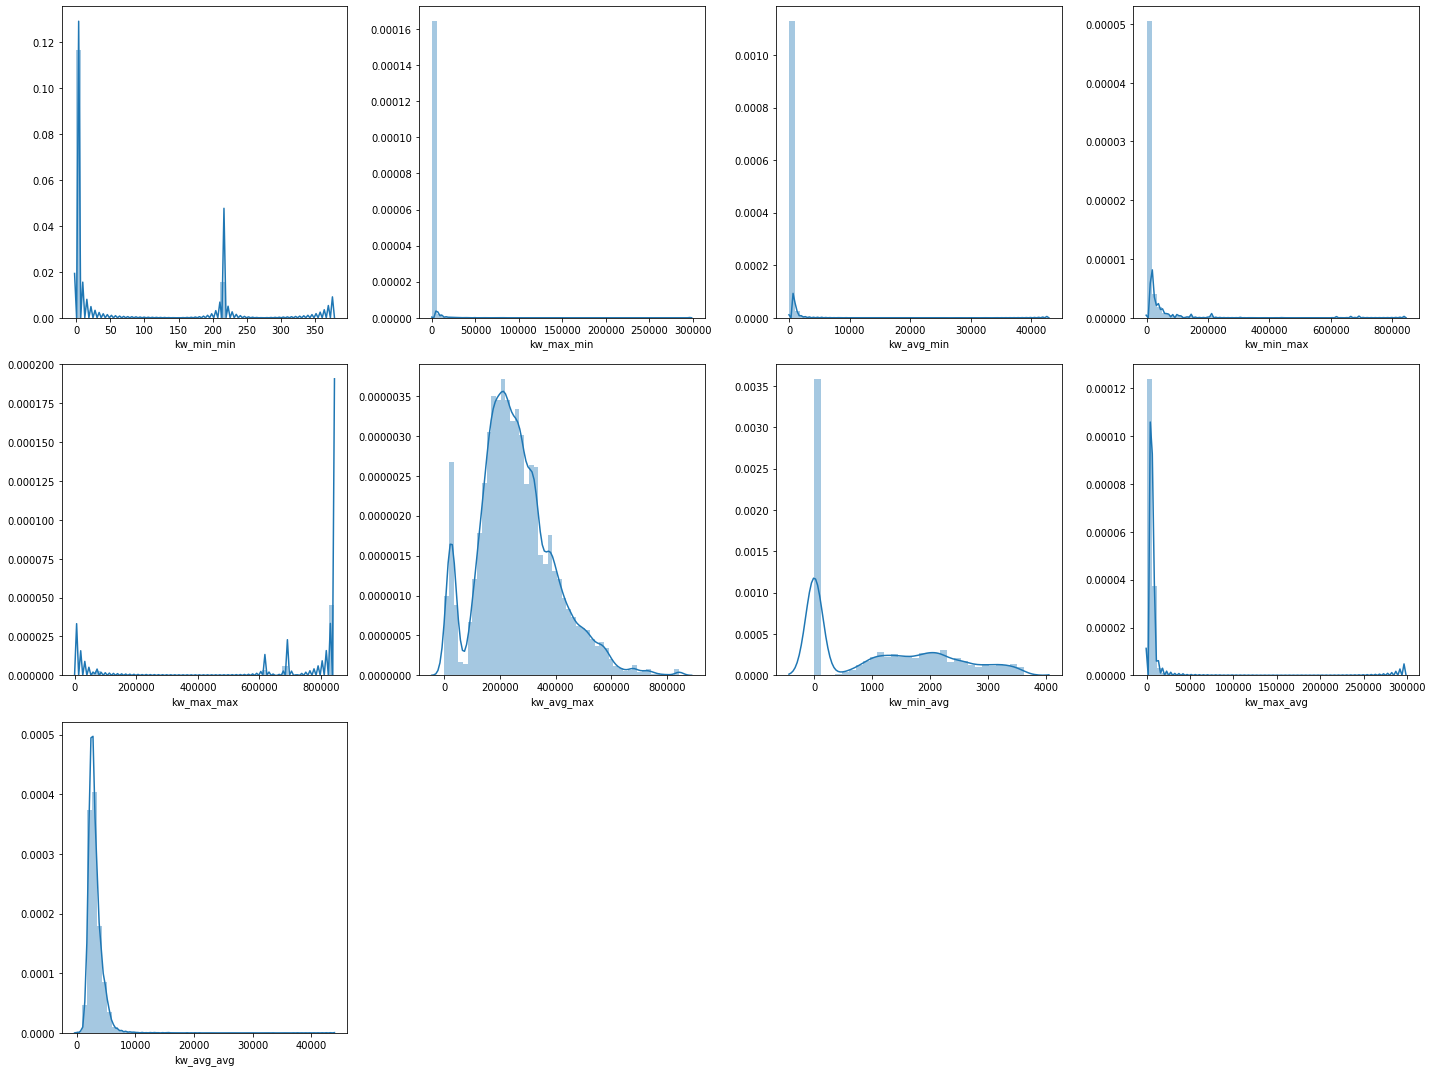

In [3]:
# Genera nuevos dataframes

qnty = df.filter(
    regex='^n_',
    axis="columns"
)

channel = df.filter(
    regex='^data_',
    axis="columns"
)

days = df.filter(
    regex=re.compile("weekday|weekend"),
    axis="columns"
)

sentiments = df.filter(
    regex=re.compile("negative|positive|subjectivity"),
    axis="columns"
)

lda = df.filter(
    regex='^LDA_\d',
    axis="columns"
)

keywords = df.filter(
    regex='^kw_', axis="columns"
)

# Genera un lista de tuplas con variables y tipo de gráfico asociado

variables = [
    (qnty, sns.distplot),
    (channel, sns.countplot),
    (days, sns.countplot),
    (sentiments, sns.distplot),
    (lda, sns.distplot),
    (keywords, sns.distplot)
]

# Genera curvas de densidad y gráficos de barra

cols = 4

for var, plot_type in variables:
    grid_plot_batch(var, cols, plot_type)
    plt.tight_layout()
    plt.show()

### Correlaciones

Se identifican las siguientes correlaciones con valor mayor a 0,8.

In [4]:
high_corr = identify_high_correlations(df, threshold=0.8)
display(high_corr)

,variable,var2,value
243,n_non_stop_words,n_unique_tokens,0.999572
303,n_non_stop_unique_tokens,n_unique_tokens,0.999852
304,n_non_stop_unique_tokens,n_non_stop_words,0.999532
1219,kw_avg_min,kw_max_min,0.940529
1338,kw_max_max,kw_min_min,-0.857226
1585,kw_avg_avg,kw_max_avg,0.811864
1767,self_reference_avg_sharess,self_reference_min_shares,0.818907
1768,self_reference_avg_sharess,self_reference_max_shares,0.853480
2417,LDA_02,data_channel_is_world,0.836618


### Preprocesamiento

Se recodifica la variable "shares" con 1 para valores mayores a 1400 y 0 de lo contrario. Además, se eliminan una columna del par de variables con alta correlación.

In [5]:
# Recodifica variables shares

df["shares"] = np.where(df["shares"] > 1400, 1, 0)

# Del par de variables con alta correlación se elimina una

df.drop(axis="columns", columns=high_corr["var2"], inplace=True)

### Análisis de componentes principales (PCA)

El análisis de componenten principales permite identificar claramente cuáles son las variables o características que aportan más información, se pueden descartar aquellas menos relevantes, reduciendo así la dimensionalidad del conjunto de datos de trabajo. De esta forma, se simplifica el problema y se agiliza todo el proceso de modelado. (Fuente: https://empresas.blogthinkbig.com/python-para-todos-que-es-el-pca/)

Una de las principales limitaciones de PCA surge cuando los datos están expresados en distintas escalas. Por ello siempre se suele hacer una normalización o estandarización previa. Por otro lado, sólo se consideran transformaciones ortogonales (rotaciones) de las variables originales. Por último, este método asume que los datos siguen una distribución normal o gaussiana. 

#### Estandarización de variables previo a PCA

In [6]:
var_objective = 'shares'
var_attributes = [x for x in df.columns if x != var_objective]

s_scaler = StandardScaler()
X = s_scaler.fit_transform(df.loc[:,var_attributes])
X = pd.DataFrame(X, columns=var_attributes)

display(X.sample(5))

,timedelta,n_tokens_title,n_tokens_content,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,average_token_length,num_keywords,...,avg_positive_polarity,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity
3319,1.487056,-0.188622,0.073201,-0.008885,0.186757,-0.335566,0.536248,-0.304268,0.290409,1.454206,...,-0.204006,-0.870968,0.174639,0.605847,0.420082,0.602906,-0.665200,-0.143502,0.484620,-0.542355
7825,1.066812,-0.661657,-0.818326,0.038946,-0.430969,0.183228,-0.546872,-0.304268,0.395251,0.406595,...,-1.459011,0.573773,-2.189185,-0.512635,-0.268895,-0.183490,-0.870807,-0.269076,0.837749,-0.689658
36692,-1.389284,0.284413,-0.519028,-0.023730,-0.783956,-0.335566,0.656594,-0.060829,-0.182615,-0.641015,...,1.358401,2.167238,0.981798,0.727016,0.420082,0.428152,-0.870807,-0.269076,0.837749,-0.689658
3325,1.487056,-0.661657,0.126268,-0.017890,-0.254476,0.702022,-0.426526,-0.304268,0.663992,-0.117210,...,-0.478723,-0.461978,0.174639,-0.027959,0.075594,0.602906,0.531059,0.244637,-1.569949,-0.087056
36732,-1.389284,2.176551,0.688780,-0.030317,-0.342723,0.702022,-0.065486,-0.304268,0.309305,-2.212431,...,-0.508507,-0.870968,0.578218,0.115890,0.075594,0.078642,-0.870807,-0.269076,0.837749,-0.689658


#### Aplicando PCA

In [7]:
# Define nombres de las columnas para los principales componentes

col_names = list(range(30))
col_names = ["comp_" + str(item).zfill(2) for item in col_names]

# Aplica PCA para obtener los principales 30 componentes y almacena datos en nuevo dataframe

pca = PCA(n_components=30)
principal_components = pca.fit_transform(X)

df_pca = pd.DataFrame(
    data=principal_components,
    columns=col_names
)

df_pca = pd.concat([df_pca, df[[var_objective]]], axis = "columns")

display(df_pca.sample(5))

,comp_00,comp_01,comp_02,comp_03,comp_04,comp_05,comp_06,comp_07,comp_08,comp_09,...,comp_21,comp_22,comp_23,comp_24,comp_25,comp_26,comp_27,comp_28,comp_29,shares
35615,-0.715959,-1.339351,1.595267,-0.412054,2.274822,2.601053,-0.915568,-0.379440,-0.639714,-1.832218,...,0.138401,-0.339091,-0.596834,-0.468258,0.452265,-0.890083,-0.928217,-0.627047,0.763709,0
29784,3.825808,2.199327,0.402032,-0.343611,-1.376966,2.156744,0.841010,1.084881,-0.039608,-0.547979,...,-0.505848,-0.554865,0.225714,0.497720,0.103418,-1.046915,-0.415809,0.183276,0.440489,0
4863,0.197969,0.519316,-2.984513,-0.966122,0.345676,-0.393680,-0.123089,0.440977,0.747514,0.639729,...,0.459458,0.301512,-0.776986,0.509275,1.018040,-1.107599,-0.240005,-0.063938,1.079743,1
32724,2.230438,1.152255,-3.218829,-0.104790,0.379033,0.713639,-0.597826,-0.703389,-0.877537,-0.089248,...,0.019015,-0.175532,1.335751,0.209632,-1.267182,-0.087540,0.636958,-0.158262,0.250029,0
16423,-1.305834,0.967230,2.011056,-0.332068,-1.367997,0.749948,-0.300216,0.470058,-0.852569,0.012451,...,-0.134128,-0.052335,-0.218147,0.694719,0.584131,0.345925,0.002411,1.214892,-0.563985,0


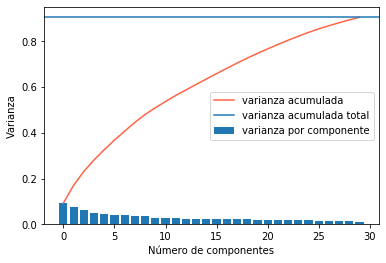

In [8]:
varianza = pca.explained_variance_ratio_

var_acum= np.cumsum(varianza)
plt.bar(range(len(varianza)), varianza, label="varianza por componente")
plt.plot(range(len(varianza)), var_acum, label="varianza acumulada", color="tomato")
plt.axhline(sum(pca.explained_variance_ratio_), label="varianza acumulada total")
plt.xlabel("Número de componentes")
plt.ylabel("Varianza")
plt.legend()
plt.show()

Los nuevos componentes explican más del 90,1% de la varianza de los datos

### División de entrenamiento

In [9]:
var_attributes = [x for x in df_pca.columns if x != var_objective]

X_train, X_test, y_train, y_test = train_test_split(
    df_pca.loc[:, var_attributes],
    df_pca.loc[:,[var_objective]],
    test_size=.33,
    random_state=8643537
)

## Evaluación de modelos individuales

- A continuación generará una serie de modelos que se incorporarán posteriormente al comité de votación. Para ello, se solicita que:
    - Importe los módulos correctamente.
    - Para cada uno de ellos, genere un reporte en las métricas de desempeño respecto a `Precision`, `Recall`, `F1`. Puede hacer uso de la función `plot_classification_report` disponible en el archivo `helpers.py`.
    - Comente el desempeño general de cada uno.
- La lista de modelos es la siguiente. Cabe destacar que la mayoría de éstos corresponden a implementaciones vanilla, salvo que se indique lo contrario:
    - Regresión Logística.
    - Algoritmo de KMedias.
    - Árbol de Clasificación con un `max_depth=1`.
    - Árbol de Clasificación con un `max_depth=4`.

### Métricas de modelos individuales

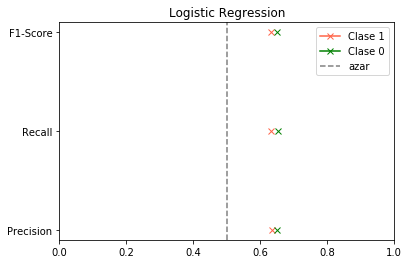

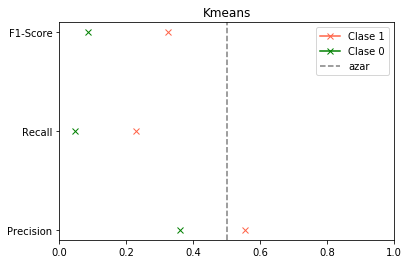

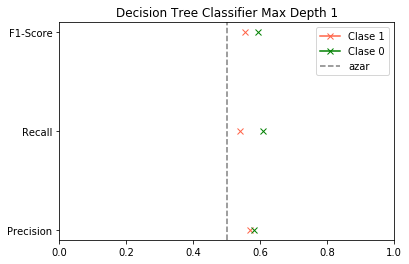

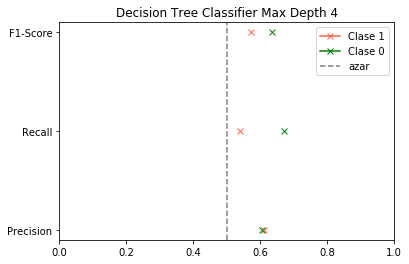

In [10]:
rep_seed = 42145

# Define estimadores

estimators = [
    (
        "Logistic Regression",
        LogisticRegression(random_state=rep_seed)
    ),
    (
        "Kmeans",
        KMeans(random_state=rep_seed)
    ),
    (
        "Decision Tree Classifier Max Depth 1",
        DecisionTreeClassifier(random_state=rep_seed, max_depth=1)
    ),
    (
        "Decision Tree Classifier Max Depth 4",
        DecisionTreeClassifier(random_state=rep_seed, max_depth=4)
    )
]

# Grafica métricas para cada estimador

for index, value in enumerate(estimators):
    model = value[1].fit(X_train, y_train)
    class_pred = model.predict(X_test)
    class_report = classification_report(y_test, class_pred, output_dict=True)
    class_report = pd.DataFrame(class_report)
    
    #display(class_report)
    
    plot_class_report(class_report, title=value[0])
    

### Comentarios de métricas
1. Todos los estimadores consiguen ser mejores con una clasificación al azar, a excepción de K-Means. 
2. 3 de los 4 modelos tienen métricas similares.
2. El mejor desempeño se lo lleva la regresión logística con todas sus métricas sobre el 60%.

## Entrenamiento de Comité
- Entrene el comité de clasificadores sin modificar el esquema de votación.
- Reporte el desempeño a nivel de cada clase para cada métrica.

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='warn', n_jobs=None, penalty='l2',
                    random_state=42145, solver='warn', tol=0.0001, verbose=0,
                    warm_start=False),
 KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
        n_clusters=8, n_init=10, n_jobs=None, precompute_distances='auto',
        random_state=42145, tol=0.0001, verbose=0),
 DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=42145, splitter='best'),
 DecisionTreeClassifier(class_weight=None, criterion='gini',

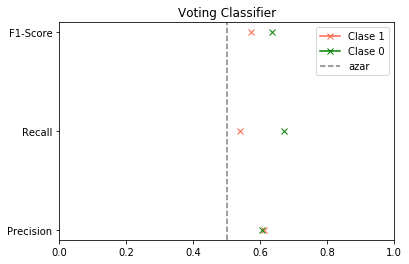

In [11]:
model_vot = VotingClassifier(estimators, voting="hard").fit(X_train, y_train)
voting_classifier_pred = model_vot.predict(X_test)
display(model_vot.estimators_)

class_report_vot = classification_report(
    y_test, voting_classifier_pred, output_dict=True)
class_report_vot = pd.DataFrame(class_report)

# display(class_report_vot)

plot_class_report(class_report_vot, title="Voting Classifier")

Todas las métricas tnedieron a los valores del estimador de Decision Tree con max_depth = 4.

## Calibración de Comité con Ponderadores
- El base al comportamiento de los clasificadores individuales del ensamble, proponga dos esquemas de ponderación para mejorar el desempeño del modelo.
- Reporte el desempeño del mejor ensamble heterogéneo.

### Propuestas de esquemas

1. **Equiprobabilidad:** Este esquema repetirá el esquema anterior, con la misma podenración para todos los modelos.
2. **Disminución/K-Means:** Este esquema disminuirá la ponderación del estimador K-Means.
3. **Aumento/K-Means:** Este esquema aumentará la ponderación del estimador K-Means.
4. **Aumento/LogisticRegression**: Este matendrá la disminución de la ponderación del estimador K-means (punto 2) y aumentará la ponderación del estimador Logistic Regression.

Text(0.5, 1, 'Esquema de Ponderación')

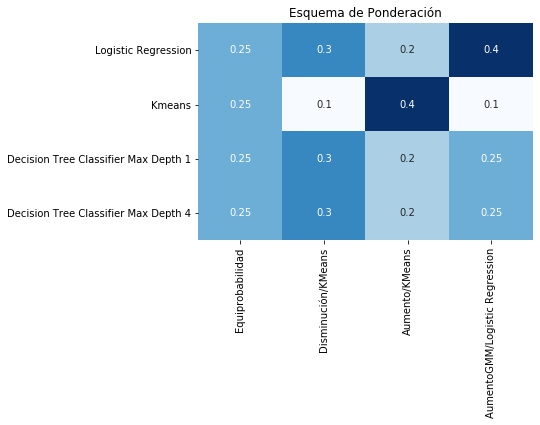

In [14]:
weights_hyperparams = {
    'Equiprobabilidad': [.25, .25, .25, .25],
    'Disminución/KMeans': [.3, .1, .3, .3],
    'Aumento/KMeans': [.2, .4, .2, .2],
    'AumentoGMM/Logistic Regression': [.4, .1, .25, .25]
}

weights = pd.DataFrame(weights_hyperparams, index=[i[0] for i in estimators])

sns.heatmap(weights, annot=True, cmap='Blues', cbar=False)
plt.title("Esquema de Ponderación")


### Desempeño

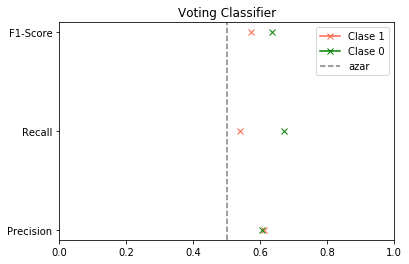

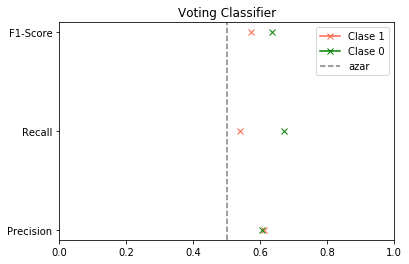

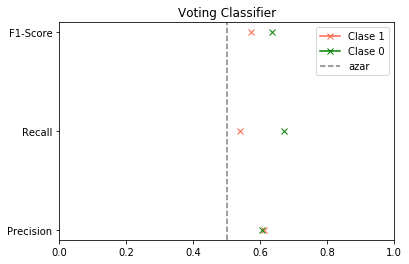

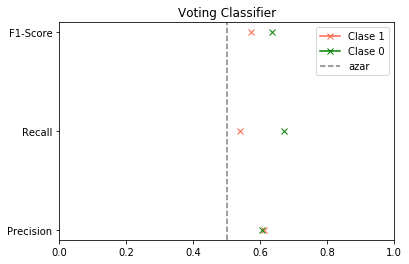

In [15]:
for i in weights:
    
    model_vot = VotingClassifier(estimators).set_params(weights=weights[i]).fit(X_train, y_train)
    
    #display(weights[i])
    #display(model_vot)
    #display(model_vot.estimators_)
    #display(model_vot.named_estimators_)
    #display(model_vot.classes_)

    
    voting_classifier_pred = model_vot.predict(X_test)

    class_report_vot = classification_report(y_test, voting_classifier_pred, output_dict=True)
    class_report_vot = pd.DataFrame(class_report)

    #display(class_report_vot)
    
    plot_class_report(class_report_vot, title="Voting Classifier")